# Title Recommendation for Indonesian News Article Using Long Short-Term Memory with Attention Mechanism - [2nd Notebook]
### Final Project of Joshia Cahyadi - 10119086
---

*Notebook* ini adalah *notebook* kedua dari 4 *notebook* lainnya. Terdapat 5 hal yang dilakukan pada *notebook* ini:
1. Mengolah data teks lebih lanjut (*tokenization* dan *padding*),
2. Mendefinisikan dan membangun model tanpa mekanisme atensi,
3. Melatih model tanpa mekanisme atensi,
4. Melakukan prediksi pada data uji (*test data*),
5. Menghitung dan menganalisis nilai BERTScore sebagai metrik evaluasi (*evaluation metric*).

# Melakukan Inisialisasi Libraries

In [ ]:
!pip install bert_score==0.3.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.1 MB/s eta 0:00:00


In [ ]:
# Libraries untuk manipulasi data
import pandas as pd
import numpy as np

# Libraries untuk interaksi dengan files
import io
import json

# Libraries untuk split data antara data training dan data validasi
from sklearn.model_selection import train_test_split

# Libraries untuk menampilkan grafik
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries untuk estetika print
import textwrap

# Libraries untuk menghitung BERTScore
# import bert_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
# Menginisialisasi data yang telah dibersihkan sebelumnya
df = pd.read_csv('/content/drive/MyDrive/Tugas Akhir 2/Files/Data Artikel 2 v3.csv')
df = df[['title','content_html']]

In [ ]:
df

,title,content_html
0,<start> tips agar resolusi tahun baru bisa men...,"hal seperti pekerjaan karir, jodoh keluarga, k..."
1,"<start> pantau tahun baru, kapolda metro jaya ...",kapolda metro jaya irjen mochamad iriawan mema...
2,<start> terompet dan kembang api bersahutan sa...,akhirnya tiba. kedatangan tahun yang baru ini ...
3,<start> awas! copet berkeliaran di ancol malam...,belasan orang mengantre di pos pengamanan sub ...
4,<start> dua gol kejutan manchester united di m...,manchester united mendulang poin sempurna atas...
...,...,...
425239,"<start> 1 januari, 107.000 kendaraan diprediks...",puncak perayaan tahun baru diprediksi akan ter...
425240,"<start> disebut akan ke barcelona, coutinho ab...",kabar perpindahan gelandang philippe coutinho ...
425241,<start> anies dan rhoma irama adu pantun hingg...,gubernur dki anies baswedan naik panggung di m...
425242,"<start> usai duet dengan rhoma, anies harap ja...",gubernur dki jakarta bernyanyi bersama rhoma i...


In [ ]:
# Menghilangkan baris yang identik
df = df.drop_duplicates()

In [ ]:
# Definisikan fungsi tag_title untuk melakukan tagging pada judul
def tag_title(title):
  tagged_article = '<start> ' + title + ' <end>'
  return tagged_article

# Definisikan fungsi lower_title untuk melakukan lowercase pada semua karakter/huruf pada judul
def lower_title(title):
  lowered_title = title.lower()
  return lowered_title

In [ ]:
# Mengaplikasikan fungsi tag_title ke semua data
df['title'] = df['title'].apply(lambda row: lower_title(tag_title(row)))

In [ ]:
# Memisahkan data untuk training dan testing model encoder-decoder sequence-to-sequence tanpa mekanisme atensi
df_training = df.sample(300000, random_state=0)
df_all = df.merge(df_training, on=['title','content_html'], how='left', indicator=True)
df_predict = df_all[df_all['_merge'] == 'left_only'][['title','content_html']]

In [ ]:
# Membuat dataframe untuk validasi
df_validating = df_predict.sample(30000, random_state=0)

In [ ]:
# Mengambil kolom 'content_html' dan 'title' untuk training
article_training = df_training['content_html']
title_training = df_training['title']

In [ ]:
# Mengambil kolom 'content_html' dan 'title' untuk validasi
article_validating = df_validating['content_html']
title_validating = df_validating['title']

In [ ]:
# Membuat dataframe untuk tes hasil prediksi
df_test = df_predict.merge(df_validating, how='left', on=['title','content_html'], indicator=True)
df_test = df_test[df_test['_merge'] == 'left_only'][['title','content_html']]

In [ ]:
df_test

,title,content_html
0,"<start> pantau tahun baru, kapolda metro jaya ...",kapolda metro jaya irjen mochamad iriawan mema...
1,<start> awas! copet berkeliaran di ancol malam...,belasan orang mengantre di pos pengamanan sub ...
2,<start> dua gol kejutan manchester united di m...,manchester united mendulang poin sempurna atas...
4,<start> warga kecewa tidak ada panggung hibura...,perayaan malam pergantian tahun baru di pada t...
5,<start> ucapan selamat tahun baru 2017 dari pa...,panglima kodam jaya mayjen teddy lhaksmana dan...
...,...,...
124311,<start> polisi as tangkap pria bersenjata jela...,"kepolisian , amerika serikat menangkap seorang..."
124312,"<start> demi jualan di monas, pedagang mengaku...",sejumlah pedagang terciduk petugas pengamanan ...
124314,<start> nike bocorkan transfer coutinho ke bar...,penantian panjang philippe coutinho untuk bers...
124315,<start> sandiaga akan saksikan hitung mundur p...,wakil gubernur dki jakarta sandiaga uno besert...


In [ ]:
import gc

del df_training
del df_all
del df

gc.collect()

124

In [ ]:
df_test.to_csv('/content/drive/MyDrive/Tugas Akhir 2/Files/Data Test Artikel 2 v3.csv')

# Pengolahan Data

In [ ]:
# Inisialisasi beberapa libraries yang dibutuhkan
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Tokenisasi

In [ ]:
# Melakukan tokenisasi untuk data training dan validasi artikel berita

## Mendefinisikan tokenizer
article_tokenizer = Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
article_tokenizer.fit_on_texts(list(article_training))

## Menerapkan tokenizer yang telah didefinisikan pada data artikel yang digunakan untuk training
article_training_tokenized = article_tokenizer.texts_to_sequences(article_training)
article_validating_tokenized = article_tokenizer.texts_to_sequences(article_validating)

## Menampilkan jumlah kosakata pada data training artikel
print('Jumlah kosakata yang ada pada data training artikel:', len(article_tokenizer.word_index) + 1, 'kosakata.')

Jumlah kosakata yang ada pada data training artikel: 665676 kosakata.


In [ ]:
# Melakukan tokenisasi untuk data training dan validasi judul berita

## Mendefinisikan tokenizer
title_tokenizer = Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
title_tokenizer.fit_on_texts(list(title_training))

## Mendefinisikan fungsi untuk judul
def getting_copies_for_title(titles, tokenizer):
  '''
  Fungsi ini digunakan untuk memisahkan judul menjadi 2 bagian:
  1. Bagian yang digunakan untuk menghitung nilai loss dari hasil perbandingan kata hasil output decoder dengan kata sebenarnya.
  2. Bagian yang digunakan sebagai kata input selanjutnya bagi decoder.
  '''

  # Menerapkan tokenizer yang telah didefinisikan pada data judul yang digunakan untuk training
  tokenized_title = tokenizer.texts_to_sequences(titles)

  # Memisahkan judul menjadi bagian input dan target
  title_decoder_input = [title[:-1] for title in tokenized_title]
  title_decoder_target = [title[1:] for title in tokenized_title]

  return title_decoder_input, title_decoder_target

## Mendapatkan bagian input dan target untuk data training bagian judul
title_training_tokenized_input, title_training_tokenized_target = getting_copies_for_title(title_training, title_tokenizer)
title_validating_tokenized_input, title_validating_tokenized_target = getting_copies_for_title(title_validating, title_tokenizer)

In [ ]:
# Menampilkan jumlah kosakata pada data training judul
print('Jumlah kosakata yang ada pada data training judul:', len(title_tokenizer.word_index)+1)

Jumlah kosakata yang ada pada data training judul: 86847


## Padding

In [ ]:
# Mendefinisikan panjang maksimal dari setiap artikel dan judul
max_len_content = 500
max_len_title = 15

In [ ]:
# Melakukan padding pada data training
article_training_padded = pad_sequences(article_training_tokenized, maxlen=max_len_content, padding='post')
title_training_padded_input = pad_sequences(title_training_tokenized_input, maxlen=max_len_title, padding='post')
title_training_padded_target = pad_sequences(title_training_tokenized_target, maxlen=max_len_title, padding='post')

In [ ]:
# Melakukan padding pada data validasi
article_validating_padded = pad_sequences(article_validating_tokenized, maxlen=max_len_content, padding='post')
title_validating_padded_input = pad_sequences(title_validating_tokenized_input, maxlen=max_len_title, padding='post')
title_validating_padded_target = pad_sequences(title_validating_tokenized_target, maxlen=max_len_title, padding='post')

# Model

In [ ]:
# Definisikan beberapa hyperparameter yang akan digunakan
input_size_article = len(article_tokenizer.word_index)+1
input_size_title = len(title_tokenizer.word_index)+1
hidden_size = 200
embedding_dim = 150
batch_size = 128
epochs = 10
dropout_rate = 0.4

In [ ]:
# Inisialisasi library TensorFlow untuk melatih model
import tensorflow as tf

from tensorflow.keras.layers import Layer, Input, LSTM, Embedding, Dense, Bidirectional, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.linalg import matmul
from tensorflow.keras.activations import softmax
from tensorflow import expand_dims, squeeze, concat, cast
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.math import not_equal
from tensorflow.data import Dataset

from keras import backend as K

K.clear_session()

## Encoder

In [ ]:
# Definisikan arsitektur encoder
class Encoder(Model):
  def __init__(self, input_dim, hidden_size, embedding_dim):
    super(Encoder, self).__init__()

    # Menginisialisasi Embedding, LSTM 1, LSTM 2, dan Concatenate layer dari Encoder
    self.encoder_embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim, name='EncoderEmbedding')
    self.encoder_lstm1 = Bidirectional(LSTM(units=hidden_size, return_sequences=True, return_state=True, dropout=dropout_rate), name='BidirectionalLSTM1')
    self.encoder_lstm2 = Bidirectional(LSTM(units=hidden_size, return_sequences=True, return_state=True, dropout=dropout_rate), name='BidirectionalLSTM2')
    self.concatenate_layer = Concatenate()

  def call(self, encoder_input):

    # Menerapkan Embedding pada input sequence
    encoder_embedding_output = self.encoder_embedding(encoder_input)

    # Menerapkan LSTM 1 dan LSTM 2 pada hasil embedding
    encoder_lstm1_output, encoder_lstm1_hidden_forward, encoder_lstm1_hidden_backward, encoder_lstm1_cell_forward, encoder_lstm1_cell_backward = self.encoder_lstm1(encoder_embedding_output)
    encoder_lstm2_output, encoder_lstm2_hidden_forward, encoder_lstm2_hidden_backward, encoder_lstm2_cell_forward, encoder_lstm2_cell_backward = self.encoder_lstm2(encoder_lstm1_output)

    # Melakukan konkatenasi untuk hidden dan cell state dari forward dan backward step
    encoder_final_hidden = self.concatenate_layer([encoder_lstm2_hidden_forward, encoder_lstm2_hidden_backward])
    encoder_final_cell = self.concatenate_layer([encoder_lstm2_cell_forward, encoder_lstm2_cell_backward])

    # Mengembalikan hasil Encoder
    return encoder_final_hidden, encoder_final_cell

## Decoder

In [ ]:
# Definisikan arsitektur decoder
class Decoder(Model):
  def __init__(self, input_dim, hidden_size, embedding_dim):
    super(Decoder, self).__init__()

    # Menginisialisasi Embedding, LSTM, Attention, Attentional, dan Dense layer untuk Decoder
    self.decoder_embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim, name='DecoderEmbedding')
    self.decoder_lstm1 = LSTM(units=hidden_size*2, return_sequences=True, return_state=True, dropout=dropout_rate, name='DecoderLSTM1')
    # self.attention = Attention()
    # self.attentional_hidden_state_layer = Dense(units=hidden_size, activation='tanh', name='AttentionalHiddenStateLayer')
    self.decoder_dense = Dense(units=input_size_title, name='DecoderDense')

  def call(self, decoder_inputs):

    decoder_input, encoder_final_states = decoder_inputs

    # Menerapkan Embedding pada input sequence
    decoder_embedding_output = self.decoder_embedding(decoder_input)

    # Menerapkan LSTM pada hasil embedding
    decoder_lstm1_output, decoder_lstm1_hidden, decoder_lstm1_cell = self.decoder_lstm1(decoder_embedding_output, initial_state=encoder_final_states)

    # Mendapatkan hasil logits
    logits = self.decoder_dense(decoder_lstm1_output)

    # Mengembalikan hasil logits, hidden state, dan cell state dari decoder
    return logits, decoder_lstm1_hidden, decoder_lstm1_cell

## Fungsi Loss

In [ ]:
# Definisikan fungsi loss
def scce_mask_loss_function(targets, predictions):

  # Inisialisasi fungsi Sparse Categorical Cross Entropy
  scce_loss = SparseCategoricalCrossentropy(from_logits=True)

  # Mendefinisikan mask agar padding tidak ikut dalam menentukan besarnya loss
  weight_mask = cast(not_equal(targets, 0), dtype=tf.float32)

  # Mengembalikan nilai loss
  return scce_loss(targets, predictions, sample_weight=weight_mask)

## Fungsi untuk Melatih Model

In [ ]:
# Definisikan fungsi untuk melatih dan melakukan validasi pada model
class SequencetoSequenceTrainingFunction(Model):
  def __init__(self, encoder, decoder):
    super(SequencetoSequenceTrainingFunction, self).__init__()

    # Menginisialisasi encoder dan decoder yang telah dibuat sebelumnya
    self.encoder = encoder
    self.decoder = decoder

  # Bagian untuk melatih model
  @tf.function
  def train_step(self, data):
    encoder_input, decoder_input, decoder_target = data

    # Inisialisasi nilai loss
    loss_val = 0.

    # Inisialisasi panjang sequence yang harus didecode oleh decoder
    decoding_length = decoder_target.shape[1]

    with tf.GradientTape() as tape:

      # Memasukkan artikel berita ke dalam encoder
      # Mendapatkan hasil berupa:
      #  1. Hidden state dari setiap timestep yang akan digunakan untuk mekanisme atensi
      #  2. Final hidden state dan final cell state yang akan digunakan untuk inisialisasi hidden state dan cell state dari decoder
      decoder_hidden, decoder_cell = self.encoder(encoder_input)

      # Looping untuk proses decoding
      for i in range(decoding_length):

        # Inisialisasi input selanjutnya yang akan masuk ke decoder
        next_decoding_input = expand_dims(decoder_input[:, i], 1)

        # Memasukkan next_decoding_input ke dalam decoder
        # Mendapatkan hasil berupa:
        #  1. logits: sebuah vektor dengan ukuran (1 x input_size_title) yang berisi nilai hasil perhitungan decoder
        #  2. Hidden state dan cell state yang akan diterukan ke decoder timestep berikutnya
        logits, decoder_hidden, decoder_cell = self.decoder([next_decoding_input, (decoder_hidden, decoder_cell)])

        # Mengakumulasi nilai loss
        loss_val += self.loss(decoder_target[:, i], logits)

    # Mendapatkan semua variabel yang dapat ditrain dalam model
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables

    # Menghitung gradient untuk backpropagation
    gradients = tape.gradient(loss_val, trainable_vars)

    # Mengaplikasikan gradient ke semua variabel yang dapat ditrain
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Mengembalikan nilai loss untuk setiap epoch
    return {'Loss': loss_val/decoding_length}

  # Bagian untuk validasi model
  @tf.function
  def test_step(self, data_validation):
    encoder_input_test, decoder_input_test, decoder_target_test = data_validation

    loss_val_test = 0.

    decoding_length_test = decoder_target_test.shape[1]

    decoder_hidden_test, decoder_cell_test = self.encoder(encoder_input_test, training=False)

    for i in range(decoding_length_test):
      next_decoding_input_test = expand_dims(decoder_input_test[:, i], 1)
      logits_test, decoder_hidden_test, decoder_cell_test = self.decoder([next_decoding_input_test, (decoder_hidden_test, decoder_cell_test)], training=False)
      loss_val_test += self.loss(decoder_target_test[:, i], logits_test)

    return {'val_loss': loss_val_test/decoding_length_test}

# Melatih Model

In [ ]:
# Inisialisasi dataset menggunakan tensorflow datasets

## Inisialisasi dataset untuk training
training_dataset = Dataset.from_tensor_slices((article_training_padded,
                                               title_training_padded_input,
                                               title_training_padded_target)).batch(batch_size, drop_remainder=True)

## Inisialisasi dataset untuk validasi
validation_dataset = Dataset.from_tensor_slices((article_validating_padded,
                                                 title_validating_padded_input,
                                                 title_validating_padded_target)).batch(batch_size, drop_remainder=True)

In [ ]:
# Inisialisasi encoder, decoder, dan optimizer
encoder = Encoder(input_dim=input_size_article, hidden_size=hidden_size, embedding_dim=embedding_dim)
decoder = Decoder(input_dim=input_size_title, hidden_size=hidden_size, embedding_dim=embedding_dim)
optimizer = tf.keras.optimizers.Adam()

# Inisialisasi model keseluruhan
model = SequencetoSequenceTrainingFunction(encoder=encoder, decoder=decoder)

# Compile model
model.compile(optimizer=optimizer, loss=scce_mask_loss_function)

In [ ]:
# Melatih model
history = model.fit(training_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/10
2343/2343 [==============================] - ETA: 0s - Loss: 4.6092

2343/2343 [==============================] - 1491s 621ms/step - Loss: 4.6089 - val_val_loss: 4.0096
Epoch 2/10
2343/2343 [==============================] - ETA: 0s - Loss: 3.5777

2343/2343 [==============================] - 1291s 551ms/step - Loss: 3.5775 - val_val_loss: 3.5305
Epoch 3/10
2343/2343 [==============================] - ETA: 0s - Loss: 3.0863

2343/2343 [==============================] - 1293s 552ms/step - Loss: 3.0861 - val_val_loss: 3.3478
Epoch 4/10
2343/2343 [==============================] - ETA: 0s - Loss: 2.7465

2343/2343 [==============================] - 1293s 552ms/step - Loss: 2.7464 - val_val_loss: 3.2935
Epoch 5/10
2343/2343 [==============================] - ETA: 0s - Loss: 2.4785

2343/2343 [==============================] - 1294s 552ms/step - Loss: 2.4784 - val_val_loss: 3.3050
Epoch 6/10
2343/2343 [==============================] - ETA: 0s - Loss: 2.2687

2343/2343 [==============================] - 1295s 553ms/step - Loss: 2.2686 - val_val_loss: 3.3406
Epoch 7/10
2343/2343 [==============================] - ETA: 0s - Loss: 2.0971

2343/2343 [==============================] - 1295s 553ms/step - Loss: 2.0970 - val_val_loss: 3.3818
Epoch 8/10
2343/2343 [==============================] - ETA: 0s - Loss: 1.9504

2343/2343 [==============================] - 1295s 553ms/step - Loss: 1.9503 - val_val_loss: 3.4305
Epoch 9/10
2343/2343 [==============================] - ETA: 0s - Loss: 1.8211

2343/2343 [==============================] - 1295s 553ms/step - Loss: 1.8210 - val_val_loss: 3.5100
Epoch 10/10
2343/2343 [==============================] - ETA: 0s - Loss: 1.7056

2343/2343 [==============================] - 1294s 552ms/step - Loss: 1.7055 - val_val_loss: 3.5586


In [ ]:
history.history['val_val_loss']

[4.009582042694092,
 3.53049635887146,
 3.347769260406494,
 3.2935006618499756,
 3.305041790008545,
 3.340557098388672,
 3.3818321228027344,
 3.4305245876312256,
 3.510035753250122,
 3.5585832595825195]

In [ ]:
# Loss manual
loss_manual = [4.6089, 3.5775, 3.0861, 2.7464, 2.4784, 2.2686, 2.0970, 1.9503, 1.8210, 1.7055]

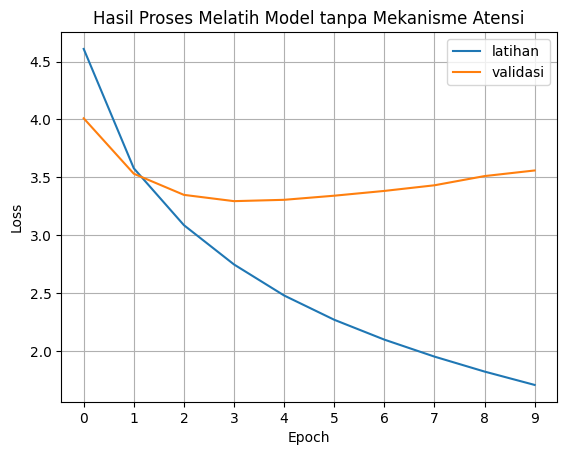

In [ ]:
# Plot hasil latihan model
import matplotlib.pyplot as plt
plt.plot(loss_manual, label='latihan')
plt.plot(history.history['val_val_loss'], label='validasi')
plt.title('Hasil Proses Melatih Model tanpa Mekanisme Atensi')
plt.xticks([i for i in range(10)])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Save encoder dan decoder
encoder.save_weights("/content/drive/MyDrive/Tugas Akhir 2/Model/Model Final/encoder_weights_v6_subclassing_new_data_v3_without_attention")
decoder.save_weights("/content/drive/MyDrive/Tugas Akhir 2/Model/Model Final/decoder_weights_v6_subclassing_new_data_v3_without_attention")

In [ ]:
# Save tokenizer
## Save article tokenizer
article_tokenizer_json = article_tokenizer.to_json()
with io.open('/content/drive/MyDrive/Tugas Akhir 2/Model/Tokenizer/article_tokenizer_v6_subclassing_new_data_v3_without_attention.json', 'w', encoding='utf-8') as f:
  f.write(json.dumps(article_tokenizer_json, ensure_ascii=False))

## Save title tokenizer
title_tokenizer_json = title_tokenizer.to_json()
with io.open('/content/drive/MyDrive/Tugas Akhir 2/Model/Tokenizer/title_tokenizer_v6_subclassing_new_data_v3_without_attention.json', 'w', encoding='utf-8') as f:
  f.write(json.dumps(title_tokenizer_json, ensure_ascii=False))

# Load Model

In [ ]:
# Load tokenizer

# Article tokenizer
with open('/content/drive/MyDrive/Tugas Akhir 2/Model/Tokenizer/article_tokenizer_v6_subclassing_new_data_v3_without_attention.json') as f:
  data = json.load(f)
  article_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

# Title tokenizer
with open('/content/drive/MyDrive/Tugas Akhir 2/Model/Tokenizer/title_tokenizer_v6_subclassing_new_data_v3_without_attention.json') as f:
  data = json.load(f)
  title_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [ ]:
encoder = Encoder(input_dim=input_size_article, hidden_size=hidden_size, embedding_dim=embedding_dim)
decoder = Decoder(input_dim=input_size_title, hidden_size=hidden_size, embedding_dim=embedding_dim)

In [ ]:
# Load model
encoder.load_weights('/content/drive/MyDrive/Tugas Akhir 2/Model/Model Final/encoder_weights_v6_subclassing_new_data_v3_without_attention')
decoder.load_weights('/content/drive/MyDrive/Tugas Akhir 2/Model/Model Final/decoder_weights_v6_subclassing_new_data_v3_without_attention')

# Melakukan prediksi

In [ ]:
# Definisikan fungsi untuk melakukan prediksi

## Fungsi ini akan menerima masukan berupa artikel berita
## Fungsi ini akan menghasilkan keluaran berupa judul berita

def generate_title_without_attention(input_text, article_tokenizer=article_tokenizer, title_tokenizer=title_tokenizer, encoder=encoder, decoder=decoder, max_title_length=15):
  input_sequence = article_tokenizer.texts_to_sequences([input_text])
  input_sequence = pad_sequences(input_sequence, maxlen=max_len_content, padding='post')

  # Inisialisasi kata pertama untuk decoder (sebagai tanda bagi decoder untuk mulai men-generate kata demi kata penyusun judul/title)
  current_word = '<start>'

  # Inisialisasi list untuk menampung kata-kata penyusun judul/title
  title_container = []

  # Mendapatkan state final (hidden state dan cell state) dari encoder yang akan dijadikan input untuk decoder
  hidden_state, cell_state = encoder.predict(input_sequence)

  while len(title_container) < max_title_length:

    # Inisialisasi vektor penampung untuk kata yang akan digunakan sebagai input untuk decoder
    input_word = np.zeros((1,1))

    # Mendapatkan index dari kata tersebut dan memasukkannnya ke dalam vektor penampung
    input_word[0, 0] = title_tokenizer.word_index[current_word]

    # Mendapatkan hasil dari decoder yang isinya
    #   1. Distribusi peluang dari semua kata yang mungkin digunakan sebagai judul
    #   2. Hidden State dan Cell State dari decoder
    decoder_output, hidden_state, cell_state = decoder.predict([input_word, (hidden_state,cell_state)], verbose=None)

    # Mendapatkan posisi (index) dari kata yang memiliki peluang tertinggi
    resulting_word_index = np.argmax(decoder_output[0])

    # Mendapatkan kata yang sebenarnya
    resulting_word = title_tokenizer.index_word[resulting_word_index]

    # Mengganti isi dari variabel current word dengan kata yang baru saja digenerate oleh Decoder, dan akan digunakan untuk input selanjutnya
    current_word = resulting_word

    # Jika kata yang digenerate oleh Decoder adalah "__end__", maka hal ini menandakan bahwa proses generate title sudah selesai
    if current_word == '<end>':
      break

    title_container.append(resulting_word)

  return " ".join(title_container)

In [ ]:
df_test['content_html'].iloc[0]

'kapolda metro jaya irjen mochamad iriawan memantau langsung ke beberapa titik pusat perayaan tahun baru di jakarta, sabtu . menggunakan sepeda motor trail, iriawan ditemani anaknya yang masih kecil. anak iriawan terlihat membonceng, mengenakan seragam brimob hitam dan menggunakan helm hitam. saya mau memantau langsung ya acara pergantian tahun naik motor ya. mau ke thamrin, monas, kota tua, dan terakhir ke ancol. karena pusatnya kan di sana, ujar iriawan. tanpa menggunakan jaket, iriawan dan putranya berangkat dari polda metro jaya dikawal sejumlah anggota kepolisian untuk mengawal menggunakan motor trail. ia mengatakan, hingga saat ini situasi masih terpantau aman dan kondusif. ia mengucapkan selamat tahun baru kepada masyarakat dan meminta masyarakat untuk bersenang senang menikmati pergantian tahun. sepanjang situasi yang ada, alhamdulillah aman, ujar iriawan'

In [ ]:
generate_title_without_attention(df_test['content_html'].iloc[0])

1/1 [==============================] - 0s 244ms/step


'kapolda metro jaya foto foto motor yang jatuh di jlnt casablanca'

In [ ]:
df_test['content_html'].iloc[18]

'banyak sampah berserakan usai perayaan malam pergantian tahun sejumlah tempat di ibu kota. menurut kadis kebersihan dki jakarta isnawa adji, total sampah diperkirakan mencapai 225 ton. mulai pukul 00.30 wib sebanyak 6000 phl pasukan oranye dinas kebersihan langsung melakukan giat pembersihan sampah di semua jalur dan titik konsentrasi massa di malam pergantian tahun baru 2017. total sampah yang berhasil dibersihkan capai 225 ton, ujar isnawa saat dihubungi detikcom, minggu . foto dok. dinas kebersihan dki jakarta isnawa menjelaskan, sebanyak 70 truk pengangkut sampah dan truk compactor telah dikerahkan untuk mengangkut sampah sampah yang berserakan usai perayaan akhir tahun itu. beberapa yang menjadi fokus pembersihan di antaranya bundaran hi, medan merdeka, patung tani, kemayoran, gelora bung karno, monas, kawasan kota tua, imam bonjol, cikini, kembangan sampai taman mini. bahkan kita sudah kerahkan 40 road sweeper, 200 gerobak motor serta 30 pick up lintas untuk mengangkut sampah, j

In [ ]:
df_test['title'].iloc[18]

'<start> usai malam tahun baru, sampah di jakarta capai 225 ton <end>'

In [ ]:
generate_title_without_attention(df_test['content_html'].iloc[18])

1/1 [==============================] - 0s 426ms/step


'sampah di jakarta timur jebol, pasukan oranye diturunkan'

In [ ]:
sample_for_prediction = df_test.sample(1000, random_state=0)

In [ ]:
sample_for_prediction['title_wo_attention'] = sample_for_prediction['content_html'].apply(lambda row: generate_title_without_attention(row))

1/1 [==============================] - 0s 262ms/step


In [ ]:
sample_for_prediction

,title,content_html,title_wo_attention
35126,"<start> pejabat pt pal tertangkap kpk, kemente...",kementerian badan usaha milik negara akan meni...,pemerintah akan tindak tegas pelaku korupsi di...
83037,<start> dua buruh bangunan isap sabu alasannya...,"dian suchairi warga jl kamboja, desa bandar kh...",warga tapos depok temukan pistol ak 47
3235,<start> bus wisata bogor 'uncal' beroperasi se...,jalan utama di sekitar istana bogor dan kebun ...,jokowi akan mampir ke ambon dengan cek sepatu ...
8349,"<start> tanggapi kicauan sby, jokowi: kita har...",presiden joko widodo menanggapi dingin kicauan...,"jokowi pemblokiran media sosial, bukan media s..."
10255,<start> ini bukti yang disita kpk saat tangkap...,undang nomor 41 tahun 2014 tentang peternakan ...,"patrialis akbar ditangkap kpk, ini alasannya"
...,...,...,...
71931,"<start> duh, indeks kebahagiaan orang indonesi...",indeks kebahagiaan rata ratamanusia indonesia ...,indonesia timur jadi brand industri perdaganga...
86855,<start> elon musk bandingkan kecerdasan buatan...,"bos spacex, , menyebut lebih berbahaya ketimba...",facebook luncurkan fitur untuk tes dna
83518,<start> ribuan santri banyumas aksi tolak prog...,ribuan massa nahdliyin di kabupaten banyumas m...,ribuan warga unjuk rasa di depan istana merdek...
65796,"<start> h-5 lebaran, kalimalang mulai ramai di...","arus lalu lintas di sisi kalimalang, bekasi, k...",pemudik motor dilarang melintas di tol cipali


# BERTScore

In [ ]:
# Menghitung nilai BERTScore
_, _, F1 = bert_score.score(sample_for_prediction['title_wo_attention'].to_list(), sample_for_prediction['content_html'].to_list(), lang='id', verbose=None)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Memasukkan BERTScore ke data
sample_for_prediction['BERTScore_wo_attention'] = F1.numpy()

In [ ]:
# Mengurutkan nilai BERTScore
sample_for_prediction['BERTScore_wo_attention'].sort_values(ascending=False)

3435     0.691448
65342    0.681326
65529    0.679688
3562     0.677923
85088    0.677896
           ...   
9575     0.533885
28348    0.531883
10196    0.530949
77539    0.528224
79005    0.522657
Name: BERTScore_wo_attention, Length: 1000, dtype: float32

In [ ]:
# Mendapatkan rataan nilai BERTScore
sample_for_prediction['BERTScore_wo_attention'].mean()

0.59864026

In [ ]:
# Menyimpan hasil dalam file csv
sample_for_prediction.to_csv('/content/drive/MyDrive/Tugas Akhir 2/Files/Hasil BERTScore Model tanpa Atensi Data 2 v3.csv')

# Analisis Hasil BERTScore

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Tugas Akhir 2/Files/Hasil BERTScore Model tanpa Atensi Data 2 v3.csv')
df

,Unnamed: 0,title,content_html,title_wo_attention,BERTScore_wo_attention
0,35126,"<start> pejabat pt pal tertangkap kpk, kemente...",kementerian badan usaha milik negara akan meni...,pemerintah akan tindak tegas pelaku korupsi di...,0.617203
1,83037,<start> dua buruh bangunan isap sabu alasannya...,"dian suchairi warga jl kamboja, desa bandar kh...",warga tapos depok temukan pistol ak 47,0.545550
2,3235,<start> bus wisata bogor 'uncal' beroperasi se...,jalan utama di sekitar istana bogor dan kebun ...,jokowi akan mampir ke ambon dengan cek sepatu ...,0.582675
3,8349,"<start> tanggapi kicauan sby, jokowi: kita har...",presiden joko widodo menanggapi dingin kicauan...,"jokowi pemblokiran media sosial, bukan media s...",0.583129
4,10255,<start> ini bukti yang disita kpk saat tangkap...,undang nomor 41 tahun 2014 tentang peternakan ...,"patrialis akbar ditangkap kpk, ini alasannya",0.646702
...,...,...,...,...,...
995,71931,"<start> duh, indeks kebahagiaan orang indonesi...",indeks kebahagiaan rata ratamanusia indonesia ...,indonesia timur jadi brand industri perdaganga...,0.583171
996,86855,<start> elon musk bandingkan kecerdasan buatan...,"bos spacex, , menyebut lebih berbahaya ketimba...",facebook luncurkan fitur untuk tes dna,0.584896
997,83518,<start> ribuan santri banyumas aksi tolak prog...,ribuan massa nahdliyin di kabupaten banyumas m...,ribuan warga unjuk rasa di depan istana merdek...,0.613402
998,65796,"<start> h-5 lebaran, kalimalang mulai ramai di...","arus lalu lintas di sisi kalimalang, bekasi, k...",pemudik motor dilarang melintas di tol cipali,0.580182


In [ ]:
# Membuat kolom "article_length" untuk mendapatkan panjang artikel berta
df['article_length'] = df['content_html'].apply(lambda row: len(row.split(' ')))

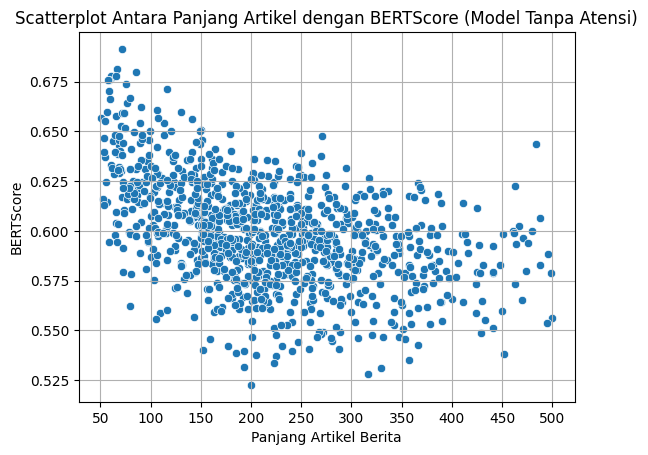

In [ ]:
# Menamplikan scatterplot antara "article_length" dengan BERTScore
sns.scatterplot(x=df['article_length'], y=df['BERTScore_wo_attention'])
plt.xlabel('Panjang Artikel Berita')
plt.ylabel('BERTScore')
plt.xticks([i*10 for i in range(5,51,5)])
plt.title('Scatterplot Antara Panjang Artikel dengan BERTScore (Model Tanpa Atensi)')
plt.grid()
plt.show()

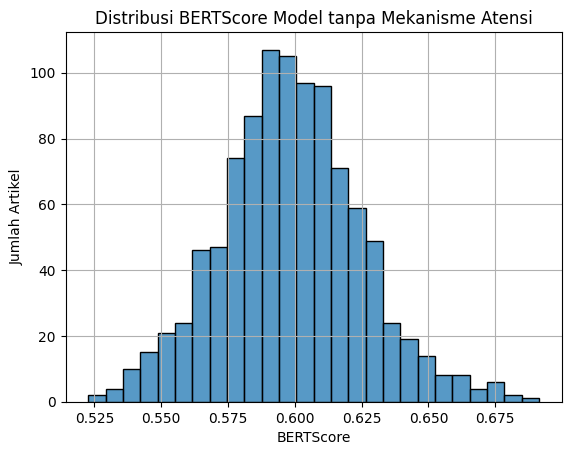

In [ ]:
# Menampilkan distribusi BERTScore
sns.histplot(df['BERTScore_wo_attention'])
plt.title('Distribusi BERTScore Model tanpa Mekanisme Atensi')
plt.xlabel('BERTScore')
plt.ylabel('Jumlah Artikel')
plt.grid()
plt.show()

# Contoh untuk Buku TA

In [ ]:
# Mengurutkan nilai BERTScore
df['BERTScore_wo_attention'].sort_values(ascending=False)

637    0.691448
488    0.681326
458    0.679688
316    0.677923
948    0.677896
         ...   
311    0.533885
14     0.531883
324    0.530949
326    0.528224
791    0.522657
Name: BERTScore_wo_attention, Length: 1000, dtype: float64

In [ ]:
df

,Unnamed: 0,title,content_html,title_wo_attention,BERTScore_wo_attention
0,35126,"<start> pejabat pt pal tertangkap kpk, kemente...",kementerian badan usaha milik negara akan meni...,pemerintah akan tindak tegas pelaku korupsi di...,0.617203
1,83037,<start> dua buruh bangunan isap sabu alasannya...,"dian suchairi warga jl kamboja, desa bandar kh...",warga tapos depok temukan pistol ak 47,0.545550
2,3235,<start> bus wisata bogor 'uncal' beroperasi se...,jalan utama di sekitar istana bogor dan kebun ...,jokowi akan mampir ke ambon dengan cek sepatu ...,0.582675
3,8349,"<start> tanggapi kicauan sby, jokowi: kita har...",presiden joko widodo menanggapi dingin kicauan...,"jokowi pemblokiran media sosial, bukan media s...",0.583129
4,10255,<start> ini bukti yang disita kpk saat tangkap...,undang nomor 41 tahun 2014 tentang peternakan ...,"patrialis akbar ditangkap kpk, ini alasannya",0.646702
...,...,...,...,...,...
995,71931,"<start> duh, indeks kebahagiaan orang indonesi...",indeks kebahagiaan rata ratamanusia indonesia ...,indonesia timur jadi brand industri perdaganga...,0.583171
996,86855,<start> elon musk bandingkan kecerdasan buatan...,"bos spacex, , menyebut lebih berbahaya ketimba...",facebook luncurkan fitur untuk tes dna,0.584896
997,83518,<start> ribuan santri banyumas aksi tolak prog...,ribuan massa nahdliyin di kabupaten banyumas m...,ribuan warga unjuk rasa di depan istana merdek...,0.613402
998,65796,"<start> h-5 lebaran, kalimalang mulai ramai di...","arus lalu lintas di sisi kalimalang, bekasi, k...",pemudik motor dilarang melintas di tol cipali,0.580182


In [ ]:
# Menghilangkan <start> dan <end> dari judul

## Definisikan fungsi untuk menghilangkan <start> dan <end>
def remove_start_end(title):
  return " ".join([word for word in title.split(' ') if word not in ['<start>','<end>']])

# Mengaplikasikan fungsi di atas ke seluruh judul
df['title'] = df['title'].apply(lambda row: remove_start_end(row))

## Contoh Pertama

In [ ]:
# Menampilkan isi artikel berita
content = df['content_html'].iloc[637]
content = textwrap.fill(content, width=100)

print('Isi Artikel Berita:')
print(content)

Isi Artikel Berita:
calon gubernur dki jakarta, , mengatakan bahwa pembangunan yang seharusnya dilakukan bukan hanya
soal pembangunan fisik dan kota yang megah. jika hanya membangun fisik, kata anies, raja mesir kuno
firaun juga bisa melakukannya sejak dulu. kalau hanya membangun kota yang megah, maka firaun pun
dulu bisa membangun kota yang megah, tetapi menghadirkan keadilan, nah itu enggak bisa karena di
sana enggak ada, ujar anies di kelurahan jati, pulogadung, jakarta timur, selasa


In [ ]:
# Menampilkan judul asli
print('Judul Asli:')
print(df['title'].iloc[637])

Judul Asli:
anies: kalau hanya bangun kota yang megah, firaun pun dulu bisa


In [ ]:
# Menampilkan judul keluaran model tanpa mekanisme atensi
print('Judul Keluaran Model tanpa Mekanisme Atensi:')
generate_title_without_attention(df['content_html'].iloc[637])

Judul Keluaran Model tanpa Mekanisme Atensi:
1/1 [==============================] - 0s 403ms/step


'anies ingin hidupkan pembangunan permukiman di jakarta timur'

In [ ]:
generate_title_without_attention(df['content_html'].iloc[637])

1/1 [==============================] - 7s 7s/step


'anies ingin hidupkan pembangunan permukiman di jakarta timur'

## Contoh Kedua

In [ ]:
# Menampilkan isi artikel berita
content = df['content_html'].iloc[488]
content = textwrap.fill(content, width=100)

print('Isi Artikel Berita:')
print(content)

Isi Artikel Berita:
posko darurat disiagakan di beberapa titik di wilayah jalur yang biasa dilintasi para pemudik. satu
di antaranya berada di . hal tersebut dinyatakan dalam acara apel ramadania 2017 di silang monas,
jakarta pusat, senin . tito menjelaskan, dalam posko tersebut disiapkan tenaga medis, montir, bensin
keliling, anggota kepolisian, dan anggota tni. posko tersebut dimaksudkan untuk melayani masyarakat
yang mengalami kesulitan, bila terjadi kemacetan parah dalam perjalanan


In [ ]:
# Menampilkan judul asli
print('Judul Asli:')
print(df['title'].iloc[488])

Judul Asli:
montir hingga tenaga medis disiagakan di posko darurat untuk bantu pemudik


In [ ]:
# Menampilkan judul keluaran model tanpa mekanisme atensi
print('Judul Keluaran Model tanpa Mekanisme Atensi:')
generate_title_without_attention(df['content_html'].iloc[488])

Judul Keluaran Model tanpa Mekanisme Atensi:
1/1 [==============================] - 0s 368ms/step


'ratusan polisi dikerahkan untuk bantu urai kemacetan di jalur mudik'

## Contoh Ketiga

In [ ]:
# Menampilkan isi artikel berita
content = df['content_html'].iloc[458]
content = textwrap.fill(content, width=100)

print('Isi Artikel Berita:')
print(content)

Isi Artikel Berita:
, jakarta aksi teror terbaru yang melanda prancis terjadi di kawasan champs elysees, senin 19 juni
2017 sore waktu setempat. seorang pria nekat menabrakkan mobil yang dikendarainya ke arah mobil
polisi. namun, aksi teror ini dapat digagalkan oleh petugas kepolisian dan keamanan prancis. tidak
ada korban tewas ataupun luka dari polisi maupun warga dalam aksi teror ini. pelaku sendiri akhirnya
tewas setelah polisi menghentikan mobilnya. dari dalam mobil pelaku, polisi menemukan sejumlah
senjata dan bahan peledak yang diduga akan digunakan untuk melakukan serangan besar di paris


In [ ]:
# Menampilkan judul asli
print('Judul Asli:')
print(df['title'].iloc[458])

Judul Asli:
serangan teror di paris, pelaku tabrakan mobilnya ke arah polisi


In [ ]:
# Menampilkan judul keluaran model tanpa mekanisme atensi
print('Judul Keluaran Model tanpa Mekanisme Atensi:')
generate_title_without_attention(df['content_html'].iloc[458])

Judul Keluaran Model tanpa Mekanisme Atensi:
1/1 [==============================] - 0s 192ms/step


'bom mobil meledak di dekat kantor polisi, pria ini tewas'

In [ ]:
# Definisikan beberapa nilai pengaturan hyperparameter
input_size_article = 665676
input_size_title = 86847
max_len_content = 500
max_len_title = 15
hidden_size = 200
embedding_dim = 150
batch_size = 128
epochs = 10
dropout_rate = 0.4

In [ ]:
!pip freeze

absl-py==1.4.0
aiohttp==3.8.4
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
array-record==0.4.0
arviz==0.15.1
astropy==5.2.2
astunparse==1.6.3
async-timeout==4.0.2
attrs==23.1.0
audioread==3.0.0
autograd==1.6.2
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blinker==1.4
blis==0.7.9
blosc2==2.0.0
bokeh==2.4.3
branca==0.6.0
build==0.10.0
CacheControl==0.13.1
cachetools==5.3.1
catalogue==2.0.8
certifi==2023.5.7
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.6
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.1.0
cons==0.4.6
contextlib2==21.6.0
contourpy==1.1.0
convertdate==2.4.0
cryptography==3.4.8
cufflinks==0.17.3
cvxopt==1.3.1
cvxpy==1.3.2
cycler==0.11.0
cymem==2.0.7
Cython==0.29.36
dask==2022.12.1
datascience==0.17.6
db-dtypes==1.1.1
d

In [ ]:
!python --version

Python 3.10.6
